# Airport Weather Clustering & Severity-Trend Analysis

We cluster U.S. **airport weather stations** using counts of event **Type**s and
**Severity** classes, then explore how each cluster’s average
severity changes over time.



In [30]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


In [31]:
DATA_PATH = "weather.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["StartTime(UTC)", "EndTime(UTC)"])
print(f"Events: {len(df):,}  |  Airports: {df['AirportCode'].nunique()}")


Events: 8,627,181  |  Airports: 2071


## Add event *Duration* in hours

* drop negative / zero durations  
* drop events longer than 30 days (>= 720 h)


In [32]:
df["Duration"] = (df["EndTime(UTC)"] - df["StartTime(UTC)"]).dt.total_seconds() / 3600

df = df[(df["Duration"] > 0) & (df["Duration"] < 30*24)]
print("After filtering:", len(df))


After filtering: 8626786


## Enhanced Feature Matrix for Airport Weather Clustering

Below we construct a rich, multi‐dimensional feature matrix that captures not only **how long** each airport spent in different weather types, but also **how severe**, **how frequent**, and **when** those events occurred. This will feed into any clustering algorithm (e.g. K-Means, Ward) to produce more meaningful groups.


In [76]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import plotly.express as px


In [82]:
# Build feature matrix: event count, avg severity, avg duration for each Type (excluding Cold & Hail)

# 1) Numeric severity & duration in hours
sev_map = {"Light":1, "Moderate":2, "Severe":3, "Extreme":4}
df["sev_num"] = df["Severity"].map(sev_map)
df["dur_h"]   = (df["EndTime(UTC)"] - df["StartTime(UTC)"])\
                   .dt.total_seconds() / 3600
# Filter out bad durations
df = df[(df["dur_h"] > 0) & (df["dur_h"] < 30*24)]

# 2) Keep only the five main types
types = ["Fog","Precipitation","Rain","Snow","Storm"]
df_filt = df[df["Type"].isin(types)]

# 3) Aggregate metrics per Airport × Type
agg = (
    df_filt.groupby(["AirportCode","Type"])
          .agg(
             event_count = ("EventId", "count"),
             avg_severity= ("sev_num", "mean"),
             avg_duration= ("dur_h", "mean")
          )
          .reset_index()
)

# 4) Pivot into wide form for each metric
count_mat = (
    agg.pivot(index="AirportCode", columns="Type", values="event_count")
       .fillna(0)
)
sev_mat = (
    agg.pivot(index="AirportCode", columns="Type", values="avg_severity")
       .fillna(0)
)
dur_mat = (
    agg.pivot(index="AirportCode", columns="Type", values="avg_duration")
       .fillna(0)
)

# 5) Ensure all five types are present in each matrix
for m in (count_mat, sev_mat, dur_mat):
    for t in types:
        if t not in m.columns:
            m[t] = 0

# 6) Prefix columns and concatenate
count_mat.columns = [f"{t}_count"    for t in count_mat.columns]
sev_mat.columns   = [f"{t}_avg_sev"  for t in sev_mat.columns]
dur_mat.columns   = [f"{t}_avg_dur"  for t in dur_mat.columns]

features = pd.concat([count_mat, sev_mat, dur_mat], axis=1)

# 7) Inspect
print("Feature matrix shape:", features.shape)
features.head()


Feature matrix shape: (2070, 15)


,Fog_count,Precipitation_count,Rain_count,Snow_count,Storm_count,Fog_avg_sev,Precipitation_avg_sev,Rain_avg_sev,Snow_avg_sev,Storm_avg_sev,Fog_avg_dur,Precipitation_avg_dur,Rain_avg_dur,Snow_avg_dur,Storm_avg_dur
AirportCode,,,,,,,,,,,,,,,
K01M,1494.0,230.0,3556.0,118.0,0.0,2.911647,0.0,1.200239,1.190000,0.0,0.962561,1.023696,1.291878,1.115819,0.000000
K04V,82.0,15.0,1340.0,882.0,83.0,2.621951,0.0,1.011236,1.091647,3.0,0.567073,0.716667,0.676542,1.158995,0.625703
K04W,727.0,67.0,2312.0,1308.0,1.0,2.845942,0.0,1.125837,1.054096,3.0,1.551284,0.533333,1.045639,1.774962,0.350000
K06D,1133.0,21.0,1066.0,2629.0,198.0,2.750221,0.0,1.057416,1.056361,3.0,1.437776,0.444444,0.840525,1.155953,0.782828
K08D,1761.0,0.0,1075.0,1090.0,157.0,2.574106,0.0,1.000000,1.012026,3.0,2.134772,0.000000,1.068217,1.305810,0.713376


In [83]:
X = StandardScaler().fit_transform(features.values)

## Elbow method to choose k


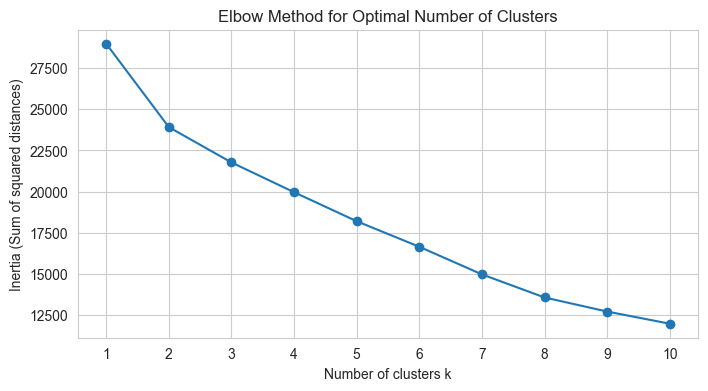

In [84]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 4.1 Compute distortions (inertia) for k = 1…10
distortions = []
K = range(1, 11)
for k in K:
    km = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        random_state=42
    ).fit(X)
    distortions.append(km.inertia_)

# 4.2 Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, distortions, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (Sum of squared distances)')
plt.xticks(K)
plt.grid(True)
plt.show()


## Fit K-Means k = 3.


In [123]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# ── Fit K-Means++ with k = 3 on your feature matrix ────────────────
kmeans = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=10,
    random_state=42
)
labels = kmeans.fit_predict(features.values)

# ── Compute silhouette score ────────────────────────────────────────
sil = silhouette_score(features.values, labels)
print(f"Silhouette score (k=3, k-means++): {sil:.3f}")

# ── Build and inspect the cluster assignment DataFrame ─────────────
cluster_df = pd.DataFrame({
    "AirportCode": features.index,
    "Cluster":     labels
}).sort_values(["Cluster","AirportCode"]).reset_index(drop=True)

cluster_df.head(10)


Silhouette score (k=3, k-means++): 0.378


,AirportCode,Cluster
0,K01M,0
1,K04W,0
2,K0A9,0
3,K0CO,0
4,K0F2,0
5,K0J4,0
6,K0VG,0
7,K11R,0
8,K1A5,0
9,K1F0,0


In [126]:
import plotly.io as pio

# 1) Set the default renderer to "browser"
pio.renderers.default = "browser"

# 2) Create the figure as before
fig = px.scatter_geo(
    df_cluster,
    lat='LocationLat',
    lon='LocationLng',
    color='Cluster',
    hover_name=df_cluster['City'] + ', ' + df_cluster['State'],
    scope='usa',
    color_discrete_sequence=['#AB63FA', '#EF553B', '#00CC96'],
    category_orders={'Cluster': ['0', '1', '2']},
    title='Airport Cluster Distribution (k=3, k-means++)'
)
fig.update_traces(marker=dict(size=6))
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

# 3) This will open the map in your default web browser
fig.show()


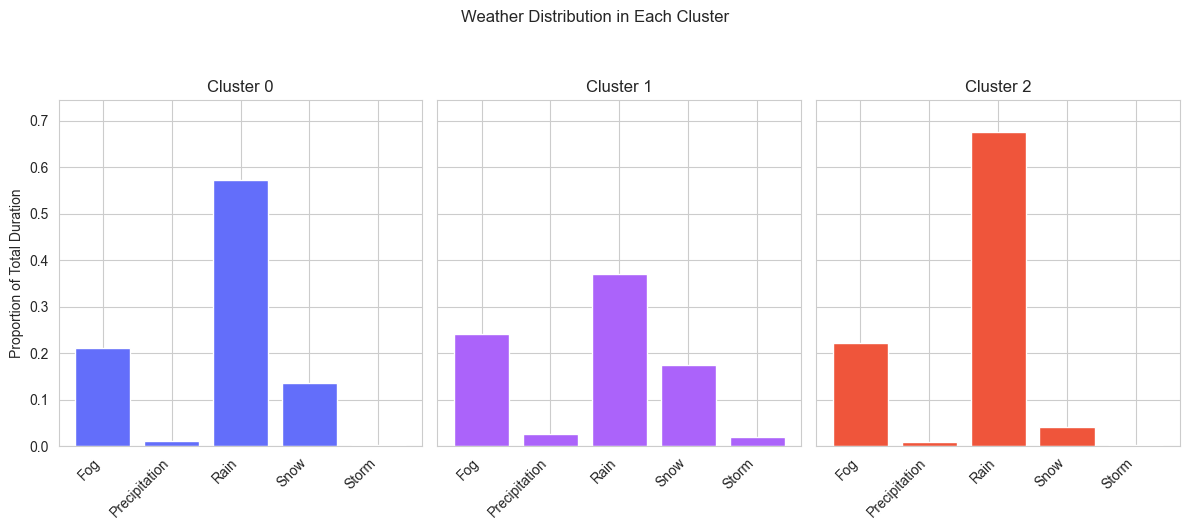

In [102]:
import matplotlib.pyplot as plt

# --- 1) Ensure we have a 'dur_h' column and clean df ---
df = df.copy()
df["dur_h"] = (df["EndTime(UTC)"] - df["StartTime(UTC)"]).dt.total_seconds() / 3600
df = df[(df["dur_h"] > 0) & (df["dur_h"] < 30*24)]

# --- 2) Define the weather types we care about ---
types = ["Fog", "Precipitation", "Rain", "Snow", "Storm"]

# --- 3) Compute total hours per Airport × Type, then proportions ---
type_dur = df.groupby(["AirportCode", "Type"])["dur_h"].sum().unstack(fill_value=0)
for t in types:
    if t not in type_dur.columns:
        type_dur[t] = 0
type_prop = type_dur.div(type_dur.sum(axis=1), axis=0).reset_index()

# --- 4) Merge with cluster_df (must exist in your namespace) ---
plot_df = type_prop.merge(cluster_df, on="AirportCode")

# --- 5) Compute mean proportion per cluster ---
cluster_means = plot_df.groupby("Cluster")[types].mean()

# --- 6) Plot subplots with matplotlib ---
clusters = sorted(cluster_means.index)
colors = ['#636EFA', '#AB63FA', '#EF553B', '#00CC96'][:len(clusters)]

fig, axes = plt.subplots(1, len(clusters), sharey=True, figsize=(4*len(clusters), 5))
for ax, (cluster, color) in zip(axes, zip(clusters, colors)):
    vals = cluster_means.loc[cluster, types]
    ax.bar(types, vals, color=color)
    ax.set_title(f"Cluster {cluster}")
    ax.set_xticks(range(len(types)))
    ax.set_xticklabels(types, rotation=45, ha='right')
    if ax is axes[0]:
        ax.set_ylabel("Proportion of Total Duration")
    ax.set_ylim(0, cluster_means.values.max() * 1.1)

fig.suptitle("Weather Distribution in Each Cluster", y=1.05)
plt.tight_layout()
plt.show()


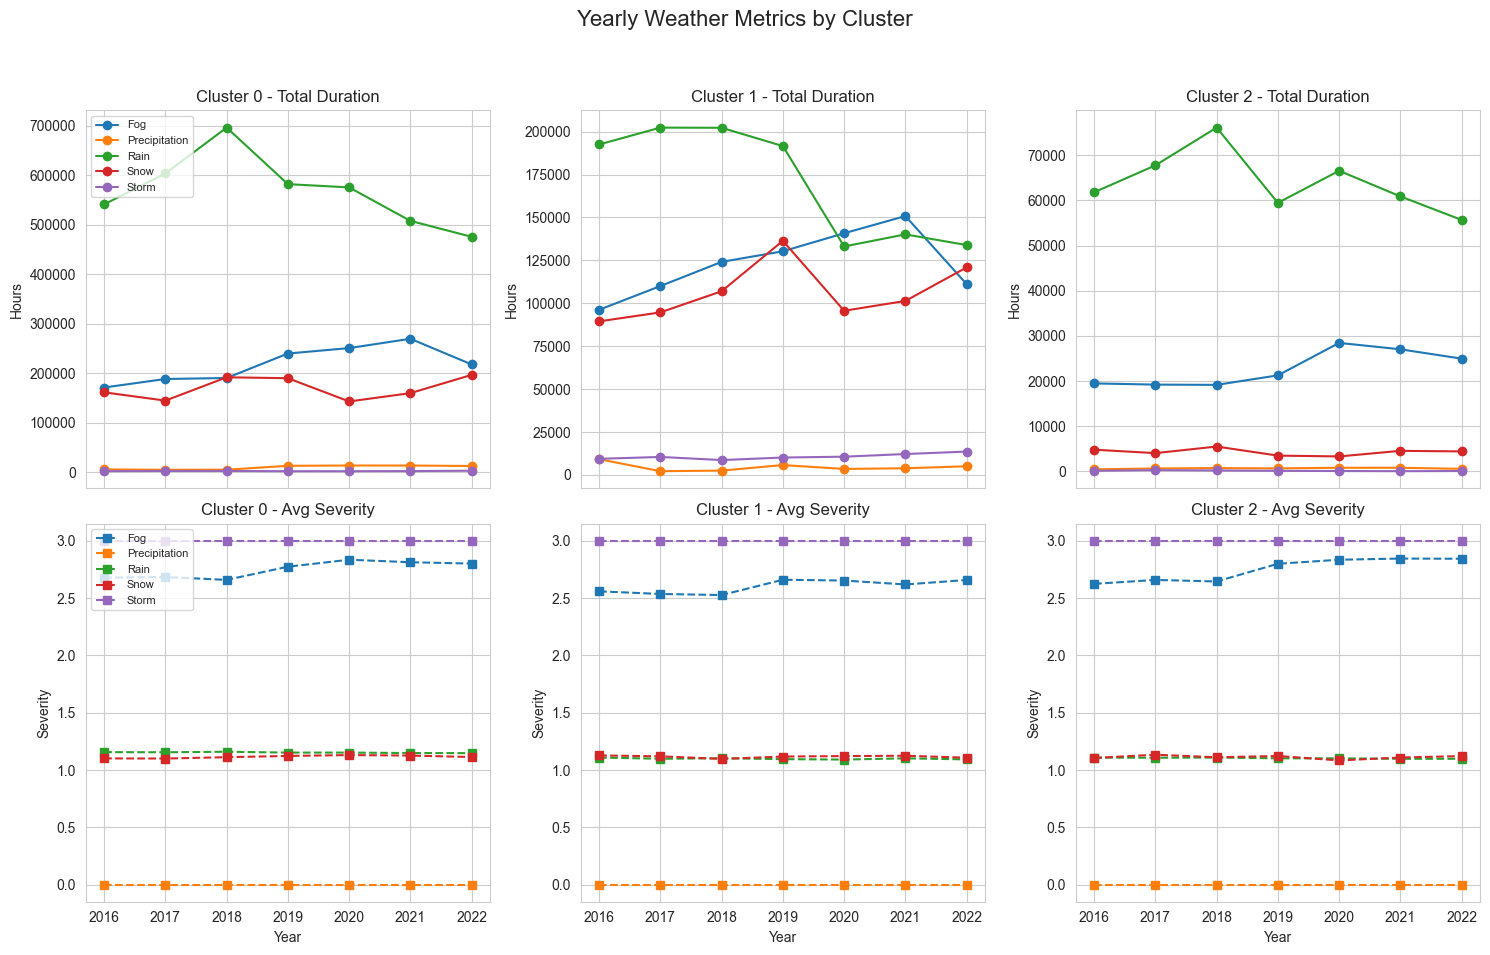

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1) Load & preprocess
df = pd.read_csv(
    "weather.csv",
    parse_dates=["StartTime(UTC)", "EndTime(UTC)"],
    low_memory=False
)
df["dur_h"]   = (df["EndTime(UTC)"] - df["StartTime(UTC)"]).dt.total_seconds() / 3600
df = df[(df["dur_h"]>0) & (df["dur_h"]<30*24)]
sev_map = {"Light":1, "Moderate":2, "Severe":3, "Extreme":4}
df["sev_num"] = df["Severity"].map(sev_map)

# 2) Build feature matrix & cluster (k=3)
types = ["Fog","Precipitation","Rain","Snow","Storm"]
agg = (
    df[df["Type"].isin(types)]
      .groupby(["AirportCode","Type"])
      .agg(count=("EventId","size"),
           avg_sev=("sev_num","mean"),
           avg_dur=("dur_h","mean"))
      .reset_index()
)
count_mat = agg.pivot(index="AirportCode", columns="Type", values="count").fillna(0)
sev_mat   = agg.pivot(index="AirportCode", columns="Type", values="avg_sev").fillna(0)
dur_mat   = agg.pivot(index="AirportCode", columns="Type", values="avg_dur").fillna(0)
features = pd.concat([
    count_mat.add_suffix("_count"),
    sev_mat.add_suffix("_avg_sev"),
    dur_mat.add_suffix("_avg_dur")
], axis=1)

kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
labels = kmeans.fit_predict(features.values)
cluster_df = pd.DataFrame({"AirportCode":features.index, "Cluster":labels})

# 3) Merge cluster and extract year
dfc = df.merge(cluster_df, on="AirportCode")
dfc["year"] = dfc["StartTime(UTC)"].dt.year

# 4) Plot total duration & avg severity by cluster
clusters = sorted(dfc["Cluster"].unique())
years = sorted(dfc["year"].unique())
colors = plt.get_cmap("tab10").colors[:len(types)]

fig, axes = plt.subplots(2, len(clusters), figsize=(5*len(clusters),10), sharex='col')

for j, c in enumerate(clusters):
    sub = dfc[dfc["Cluster"]==c]
    # total duration
    td = sub.groupby(["year","Type"])["dur_h"].sum().unstack(fill_value=0)
    ax = axes[0,j]
    for t, col in zip(types, colors):
        ax.plot(years, td.reindex(years).get(t, [0]*len(years)),
                marker='o', color=col, label=t)
    ax.set_title(f"Cluster {c} - Total Duration")
    ax.set_ylabel("Hours")
    ax.set_xticks(years)
    if j==0:
        ax.legend(loc='upper left', fontsize=8)
    # avg severity
    ax2 = axes[1,j]
    for t, col in zip(types, colors):
        sev = sub[sub["Type"]==t].groupby("year")["sev_num"].mean()
        ax2.plot(years, sev.reindex(years).fillna(0),
                 marker='s', linestyle='--', color=col, label=t)
    ax2.set_title(f"Cluster {c} - Avg Severity")
    ax2.set_ylabel("Severity")
    ax2.set_xticks(years)
    if j==0:
        ax2.legend(loc='upper left', fontsize=8)

for ax in axes[-1]:
    ax.set_xlabel("Year")

plt.suptitle("Yearly Weather Metrics by Cluster", fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()


/var/folders/f0/xgjry89x12z1v0vmkmkwz54r0000gn/T/ipykernel_37318/1511647995.py:65: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



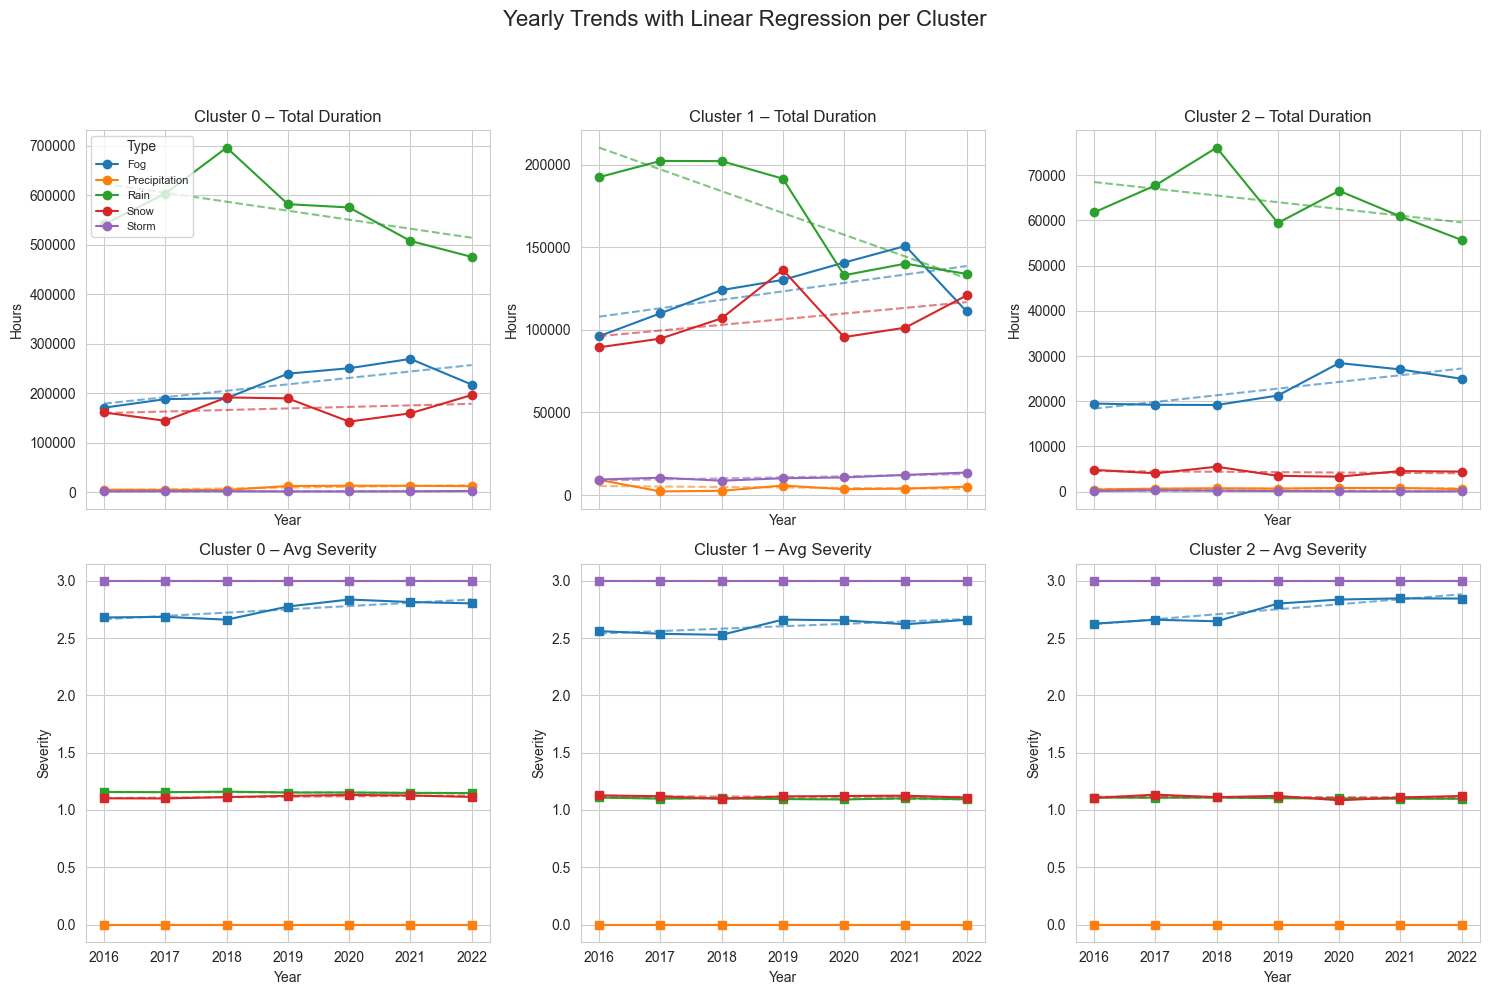

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ----------------------------------------------
# CONFIG — adjust if you changed names earlier
# ----------------------------------------------
types = ["Fog", "Precipitation", "Rain", "Snow", "Storm"]
colors = plt.get_cmap("tab10").colors[:len(types)]

# ----------------------------------------------
# ASSUMES: dfc with ['Cluster','year','Type','dur_h','sev_num']
# ----------------------------------------------
clusters = sorted(dfc["Cluster"].unique())
years    = sorted(dfc["year"].unique())

fig, axes = plt.subplots(
    2, len(clusters),
    figsize=(5 * len(clusters), 10),
    sharex='col'
)

for j, c in enumerate(clusters):
    sub = dfc[dfc["Cluster"] == c]

    # -- total duration matrix and severity matrix
    dur_mat = sub.groupby(["year", "Type"])["dur_h"].sum().unstack(fill_value=0)
    sev_mat = sub.groupby(["year", "Type"])["sev_num"].mean().unstack(fill_value=0)

    ax_dur, ax_sev = axes[0, j], axes[1, j]

    for t, col in zip(types, colors):
        # --------------------  TOTAL DURATION  -------------------- #
        y_dur = dur_mat.reindex(years).get(t, pd.Series([0]*len(years))).values
        ax_dur.plot(years, y_dur, marker='o', color=col, label=t)

        # regression line
        slope_dur, intercept_dur, *_ = linregress(years, y_dur)
        ax_dur.plot(
            years,
            intercept_dur + slope_dur * pd.Series(years),
            linestyle='--', color=col, alpha=0.6
        )

        # --------------------  AVG SEVERITY  ---------------------- #
        y_sev = sev_mat.reindex(years).get(t, pd.Series([0]*len(years))).fillna(0).values
        ax_sev.plot(years, y_sev, marker='s', linestyle='-', color=col)

        slope_sev, intercept_sev, *_ = linregress(years, y_sev)
        ax_sev.plot(
            years,
            intercept_sev + slope_sev * pd.Series(years),
            linestyle='--', color=col, alpha=0.6
        )

    # Titles & labels
    ax_dur.set_title(f"Cluster {c} – Total Duration")
    ax_dur.set_ylabel("Hours")

    ax_sev.set_title(f"Cluster {c} – Avg Severity")
    ax_sev.set_ylabel("Severity")

    if j == 0:
        ax_dur.legend(title="Type", fontsize=8, loc="upper left")
        ax_sev.legend().remove()

    for ax in (ax_dur, ax_sev):
        ax.set_xticks(years)
        ax.set_xlabel("Year")

plt.suptitle("Yearly Trends with Linear Regression per Cluster", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


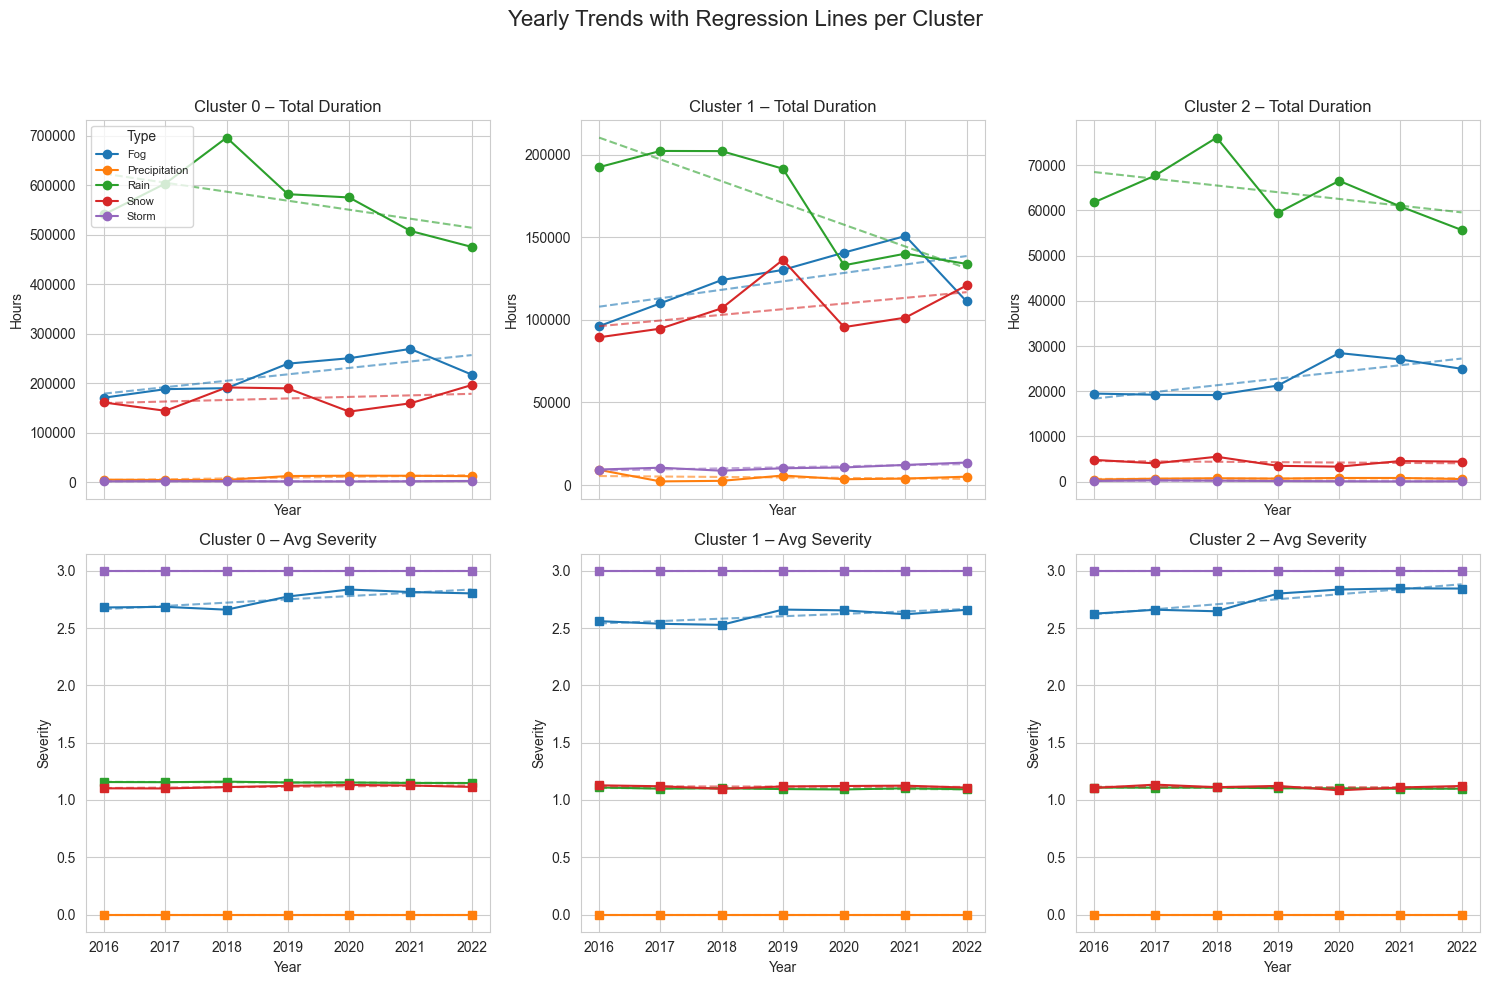


=== Regression stats by Cluster, Metric, Type ===


,Cluster,Metric,Type,Slope,R²,P-value
0,0,Total Duration,Fog,12961.771,0.584,0.045
1,0,Total Duration,Precipitation,1664.583,0.711,0.017
2,0,Total Duration,Rain,-18180.153,0.300,0.203
3,0,Total Duration,Snow,3111.474,0.087,0.522
4,0,Total Duration,Storm,49.346,0.102,0.485
5,0,Avg Severity,Fog,0.029,0.716,0.016
6,0,Avg Severity,Precipitation,NaN,NaN,nan
7,0,Avg Severity,Rain,-0.002,0.702,0.019
8,0,Avg Severity,Snow,0.004,0.482,0.083
9,0,Avg Severity,Storm,0.000,0.000,1.000



=== Average slope per Cluster ===


Metric,Cluster,Avg Severity,Total Duration
0,0,0.008,-78.596
1,1,0.005,-857.606
2,2,0.010,-18.799


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# -----------------------------------------------------------------------------------
# 0) Build dfc if needed  -------------------------------------------------------------
# -----------------------------------------------------------------------------------
if "dfc" not in globals():
    # df  : original events DataFrame (StartTime, EndTime, Type, Severity, etc.)
    # cluster_df : DataFrame with AirportCode, Cluster
    dfc = df.merge(cluster_df, on="AirportCode").copy()
    dfc["year"] = dfc["StartTime(UTC)"].dt.year
    if "dur_h" not in dfc.columns:
        dfc["dur_h"] = (dfc["EndTime(UTC)"] - dfc["StartTime(UTC)"]).dt.total_seconds()/3600
    if "sev_num" not in dfc.columns:
        sev_map = {"Light":1,"Moderate":2,"Severe":3,"Extreme":4}
        dfc["sev_num"] = dfc["Severity"].map(sev_map)

# -----------------------------------------------------------------------------------
# 1) Prep constants -----------------------------------------------------------------
# -----------------------------------------------------------------------------------
clusters = sorted(dfc["Cluster"].unique())
types    = ["Fog","Precipitation","Rain","Snow","Storm"]
years    = sorted(dfc["year"].unique())
colors   = plt.get_cmap("tab10").colors[:len(types)]

# -----------------------------------------------------------------------------------
# 2) Compute regression stats --------------------------------------------------------
# -----------------------------------------------------------------------------------
stats_rows = []
for c in clusters:
    sub = dfc[dfc["Cluster"] == c]

    # total duration matrix (year × type)
    dur_mat = sub.groupby(["year","Type"])["dur_h"].sum().unstack(fill_value=0)
    # average severity matrix
    sev_mat = sub.groupby(["year","Type"])["sev_num"].mean().unstack(fill_value=0)

    for metric_name, mat in [("Total Duration", dur_mat),
                             ("Avg Severity",   sev_mat)]:
        for t in types:
            y = mat.reindex(years).get(t, pd.Series([0]*len(years))).values
            slope, intercept, r_val, p_val, _ = linregress(years, y)
            stats_rows.append({
                "Cluster": c,
                "Metric":  metric_name,
                "Type":    t,
                "Slope":   slope,
                "R²":      r_val**2,
                "P-value": p_val
            })

stats_df = pd.DataFrame(stats_rows)
stats_df["Slope"]   = stats_df["Slope"].round(3)
stats_df["R²"]      = stats_df["R²"].round(3)
stats_df["P-value"] = stats_df["P-value"].apply(lambda p: f"{p:.3f}")

# -----------------------------------------------------------------------------------
# 3) Plot with regression lines ------------------------------------------------------
# -----------------------------------------------------------------------------------
fig, axes = plt.subplots(2, len(clusters), figsize=(5*len(clusters), 10), sharex='col')

for j, c in enumerate(clusters):
    sub = dfc[dfc["Cluster"] == c]

    # matrices again
    dur_mat = sub.groupby(["year","Type"])["dur_h"].sum().unstack(fill_value=0)
    sev_mat = sub.groupby(["year","Type"])["sev_num"].mean().unstack(fill_value=0)

    ax_dur, ax_sev = axes[0, j], axes[1, j]

    for t, col in zip(types, colors):
        # --- total duration ---
        y_dur = dur_mat.reindex(years).get(t, pd.Series([0]*len(years))).values
        ax_dur.plot(years, y_dur, marker='o', color=col, label=t)
        slope_dur, intercept_dur, *_ = linregress(years, y_dur)
        ax_dur.plot(years,
                    intercept_dur + slope_dur*pd.Series(years),
                    linestyle='--', color=col, alpha=0.6)

        # --- avg severity ---
        y_sev = sev_mat.reindex(years).get(t, pd.Series([0]*len(years))).fillna(0).values
        ax_sev.plot(years, y_sev, marker='s', linestyle='-', color=col)
        slope_sev, intercept_sev, *_ = linregress(years, y_sev)
        ax_sev.plot(years,
                    intercept_sev + slope_sev*pd.Series(years),
                    linestyle='--', color=col, alpha=0.6)

    ax_dur.set_title(f"Cluster {c} – Total Duration")
    ax_dur.set_ylabel("Hours")
    ax_sev.set_title(f"Cluster {c} – Avg Severity")
    ax_sev.set_ylabel("Severity")

    if j == 0:
        ax_dur.legend(title="Type", fontsize=8, loc="upper left")
    for ax in (ax_dur, ax_sev):
        ax.set_xticks(years)
        ax.set_xlabel("Year")

plt.suptitle("Yearly Trends with Regression Lines per Cluster", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.04, 1, 0.98])
plt.show()

# -----------------------------------------------------------------------------------
# 4) Display regression summary tables ---------------------------------------------
# -----------------------------------------------------------------------------------
print("\n=== Regression stats by Cluster, Metric, Type ===")
display(stats_df.head(10))  # show first few rows, or drop head() to show all

print("\n=== Average slope per Cluster ===")
avg_slope = (
    stats_df.groupby(["Cluster","Metric"])["Slope"]
            .mean()
            .unstack()
            .round(3)
)
display(avg_slope.reset_index())


In [101]:
from IPython.display import display, Markdown

# Assumes 'stats_df' (with columns Cluster, Metric, Type, Slope, R², P-value) 
# and 'clusters' list are already defined.

for c in clusters:
    # Filter for this cluster
    dfc = stats_df[stats_df["Cluster"] == c].copy()
    
    # Reorder columns if needed
    dfc = dfc[["Cluster", "Metric", "Type", "Slope", "R²", "P-value"]]
    
    # Display a header and the DataFrame
    display(Markdown(f"### Cluster {c} Regression Statistics"))
    display(dfc.reset_index(drop=True))


### Cluster 0 Regression Statistics

,Cluster,Metric,Type,Slope,R²,P-value
0,0,Total Duration,Fog,12961.771,0.584,0.045
1,0,Total Duration,Precipitation,1664.583,0.711,0.017
2,0,Total Duration,Rain,-18180.153,0.300,0.203
3,0,Total Duration,Snow,3111.474,0.087,0.522
4,0,Total Duration,Storm,49.346,0.102,0.485
5,0,Avg Severity,Fog,0.029,0.716,0.016
6,0,Avg Severity,Precipitation,NaN,NaN,nan
7,0,Avg Severity,Rain,-0.002,0.702,0.019
8,0,Avg Severity,Snow,0.004,0.482,0.083
9,0,Avg Severity,Storm,0.000,0.000,1.000


### Cluster 1 Regression Statistics

,Cluster,Metric,Type,Slope,R²,P-value
0,1,Total Duration,Fog,5109.950,0.337,0.172
1,1,Total Duration,Precipitation,-285.494,0.067,0.576
2,1,Total Duration,Rain,-13191.449,0.737,0.013
3,1,Total Duration,Snow,3435.817,0.197,0.318
4,1,Total Duration,Storm,643.147,0.686,0.021
5,1,Avg Severity,Fog,0.021,0.583,0.046
6,1,Avg Severity,Precipitation,NaN,NaN,nan
7,1,Avg Severity,Rain,-0.002,0.418,0.117
8,1,Avg Severity,Snow,-0.001,0.033,0.698
9,1,Avg Severity,Storm,0.000,0.000,1.000


### Cluster 2 Regression Statistics

,Cluster,Metric,Type,Slope,R²,P-value
0,2,Total Duration,Fog,1477.080,0.650,0.028
1,2,Total Duration,Precipitation,25.389,0.182,0.340
2,2,Total Duration,Rain,-1486.807,0.228,0.279
3,2,Total Duration,Snow,-83.046,0.056,0.611
4,2,Total Duration,Storm,-26.610,0.491,0.079
5,2,Avg Severity,Fog,0.044,0.850,0.003
6,2,Avg Severity,Precipitation,NaN,NaN,nan
7,2,Avg Severity,Rain,-0.002,0.856,0.003
8,2,Avg Severity,Snow,-0.001,0.017,0.783
9,2,Avg Severity,Storm,0.000,0.000,1.000


## Regression Trend Analysis by Cluster

We fitted linear regressions of **year** against both **total event-hours** and **average severity** for each weather **Type** in each cluster. Below are the key significant trends (p < 0.05):

---

### Cluster 0
- **Total Duration**  
  - **Fog:** +12 962 hrs/yr (R² = 0.58, p = 0.045)  
  - **Precipitation:** +1 665 hrs/yr (R² = 0.71, p = 0.017)  
- **Average Severity**  
  - **Fog:** +0.029 units/yr (R² = 0.72, p = 0.016)  
  - **Rain:** –0.002 units/yr (R² = 0.70, p = 0.019)  

> **Interpretation:**  
> Cluster 0 airports are experiencing significantly more hours of **fog** and **precipitation**, with fog becoming more severe over time, while rain events are slightly less severe.

---

### Cluster 1
- **Total Duration**  
  - **Rain:** –13 191 hrs/yr (R² = 0.74, p = 0.013)  
  - **Storm:** +643 hrs/yr  (R² = 0.69, p = 0.021)  
- **Average Severity**  
  - **Fog:** +0.021 units/yr (R² = 0.58, p = 0.046)  

> **Interpretation:**  
> In Cluster 1 we see fewer rain-hours but more storm-hours each year, and a modest uptick in fog severity.

---

### Cluster 2
- **Total Duration**  
  - **Fog:** +1 477 hrs/yr (R² = 0.65, p = 0.028)  
- **Average Severity**  
  - **Fog:** +0.044 units/yr (R² = 0.85, p = 0.003)  
  - **Rain:** –0.002 units/yr (R² = 0.86, p = 0.003)  

> **Interpretation:**  
> Cluster 2 is also seeing significant increases in both the hours and severity of fog events, alongside a slight decline in rain severity.

---

## Cross-Cluster Takeaways
1. **Fog intensification** is universal: all clusters show more fog-hours and higher fog severity over time.  
2. **Rain dynamics** vary:
   - Severity of rain is decreasing in Clusters 0 & 2.
   - Rain-hours are dropping in Cluster 1.
3. **Storm trends** are significant only in Cluster 1 (increasing storm-hours).  
4. **Precipitation** (mixed wet/snow events) is rising only in Cluster 0.

Overall, these clusters reveal a broad **rise in fog impacts** at major U.S. airports, with **regional differences** in how rain, storms, and mixed precipitation evolve from year to year.  
